In [1]:
from aifeel.util import gen_dataframe, read_corpus
from aifeel.util.preprocess import preprocess_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import numpy as np



In [2]:
# Read the corpora and word lists
negative_corpus, positive_corpus = read_corpus("negative-reviews"), read_corpus("positive-reviews")
negative_words, positive_words = set(read_corpus("negative-words")), set(read_corpus("positive-words"))

# Generate the dataframe and preprocess the reviews
df = gen_dataframe(positive_corpus, negative_corpus, random_state=42)
df["clean_review"] = df["review"].apply(preprocess_text)

In [3]:
df['clean_review'].head(5)

0                                                 none
1    color internet ringtones camera w flash charge...
2    small screen low battery life can be upgrade n...
3                     near photo perfect print quality
4                                   short battery life
Name: clean_review, dtype: object

In [4]:
none_count = df[df["clean_review"] == "none"].shape[0]
print(f"There are {none_count} rows with 'none' in the clean_review column.")

There are 757 rows with 'none' in the clean_review column.


In [5]:
df = df[df["clean_review"] != "none"]

In [6]:
df['clean_review'].head(5)

1    color internet ringtones camera w flash charge...
2    small screen low battery life can be upgrade n...
3                     near photo perfect print quality
4                                   short battery life
5                      less than perfect photo quality
Name: clean_review, dtype: object

In [7]:
def count_sentiment_words(review, sentiment_words):
    words = review.split()
    return sum(1 for word in words if word in sentiment_words)

In [8]:
df['positive_word_count'] = df['clean_review'].apply(lambda review: count_sentiment_words(review, positive_words))
df['negative_word_count'] = df['clean_review'].apply(lambda review: count_sentiment_words(review, negative_words))

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
X_train, y_train = train_df.drop('tag', axis=1), train_df['tag']
X_test, y_test = test_df.drop('tag', axis=1), test_df['tag']

In [11]:
#apply tf-idf
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train['clean_review'])
X_test_tfidf = vectorizer.transform(X_test['clean_review'])

In [12]:
print(vectorizer.get_feature_names_out())
print(X_test_tfidf.toarray())

['00' '00 and' '00 cost' ... 'zoon in' 'zzooomm' 'zzooomm overall']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### uncomment this code if you want to concatenate the positive and ngative words count feature with the tfidf but that would be computing cost 

In [13]:
from scipy.sparse import hstack
# Concatenate the TF-IDF features with the sentiment word count features
X_train_features = hstack([X_train_tfidf, X_train[['positive_word_count', 'negative_word_count']].values])
X_test_features = hstack([X_test_tfidf, X_test[['positive_word_count', 'negative_word_count']].values])

In [14]:
# # Define the hyperparameters
# hyperparameters = {
#     "LogisticRegression": {"C": [0.1, 1, 10, 100]},
#     "DecisionTreeClassifier": {"max_depth": [5, 10, 15, 20]},
#     "RandomForestClassifier": {"n_estimators": [100, 200, 300], "max_depth": [10, 20, 30]},
#     "MultinomialNB": {"alpha": [0.1, 0.5, 1]}
# }

# # Define the models
# models = {
#     "LogisticRegression": LogisticRegression(),
#     "DecisionTreeClassifier": DecisionTreeClassifier(),
#     "RandomForestClassifier": RandomForestClassifier(),
#     "MultinomialNB": MultinomialNB()
# }

# # Perform hyperparameter tuning for each model
# for model_name, model in models.items():
#     clf = GridSearchCV(model, hyperparameters[model_name], cv=5)
#     clf.fit(X_train, y_train)
#     print(f"Best parameters for {model_name}: {clf.best_params_}")
#     y_pred = clf.predict(X_test)
#     print(f"Classification report for {model_name}:\n")
#     print(classification_report(y_test, y_pred))


best paramter: 
Best parameters for LogisticRegression: {'C': 10} <br>
Best parameters for DecisionTreeClassifier: {'max_depth': 20} <br>
Best parameters for RandomForestClassifier: {'max_depth': 30, 'n_estimators': 300} <br>


In [15]:
from sklearn.metrics import classification_report

# Initialize a dictionary to hold the trained models
models = {
    "LogisticRegression": LogisticRegression(C=10),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=20),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=300, max_depth=30),
    "MultinomialNB": MultinomialNB(alpha=1)  # Assuming alpha=1 is the best parameter for MultinomialNB
}


# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_features, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test_features)
    
    # Evaluate the model
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))


d:\CS-Term 10\NLP\Mini Project 2\aifeel\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3839
           1       0.95      0.94      0.95      4010

    accuracy                           0.95      7849
   macro avg       0.95      0.95      0.95      7849
weighted avg       0.95      0.95      0.95      7849

Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3839
           1       0.92      0.89      0.91      4010

    accuracy                           0.91      7849
   macro avg       0.91      0.91      0.91      7849
weighted avg       0.91      0.91      0.91      7849

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3839
           1       0.94      0.88      0.91      4010

    accuracy                        

In [16]:
def predict_review(model, reviews):
    X_tfidf = vectorizer.transform(reviews)
    
    positive_word_count = [count_sentiment_words(review, positive_words) for review in reviews]
    negative_word_count = [count_sentiment_words(review, negative_words) for review in reviews]
    
    # Combine the tf-idf features with the sentiment word count features
    X = hstack([X_tfidf, np.array([positive_word_count, negative_word_count]).T])
    
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    
    for review, pred, prob in zip(reviews, y_pred, y_prob):
        sentiment = 'Positive' if pred == "1" else 'Negative'
        print(f"Review: {review} ({sentiment})\nProbability (Negative, Positive): {prob}\n")


In [17]:
reviews = [
    "Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8\".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.",
    "I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",
    "I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",
    "This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!",
    "I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.",
    "I aded this in my basket at hte last mintue to see what it would look like in person. (store pick up). i went with teh darkler color only because i am so pale :-) hte color is really gorgeous, and turns out it mathced everythiing i was trying on with it prefectly. it is a little baggy on me and hte xs is hte msallet size (bummer, no petite). i decided to jkeep it though, because as i said, it matvehd everything. my ejans, pants, and the 3 skirts i waas trying on (of which i ]kept all ) oops.",
    "I ordered this in carbon for store pick up, and had a ton of stuff (as always) to try on and used this top to pair (skirts and pants). everything went with it. the color is really nice charcoal with shimmer, and went well with pencil skirts, flare pants, etc. my only compaint is it is a bit big, sleeves are long and it doesn't go in petite. also a bit loose for me, but no xxs... so i kept it and wil ldecide later since the light color is already sold out in hte smallest size...",
    "I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.",
    "I'm 5\"5' and 125 lbs. i ordered the s petite to make sure the length wasn't too long. i typically wear an xs regular in retailer dresses. if you're less busty (34b cup or smaller), a s petite will fit you perfectly (snug, but not tight). i love that i could dress it up for a party, or down for work. i love that the tulle is longer then the fabric underneath.",
    "Dress runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas dress this year! needless to say it will be going back.",
    "This dress is perfection! so pretty and flattering.",
    "More and more i find myself reliant on the reviews written by savvy shoppers before me and for the most past, they are right on in their estimation of the product. in the case of this dress-if it had not been for the reveiws-i doubt i would have even tried this. the dress is beautifully made, lined and reminiscent of the old retailer quality. it is lined in the solid periwinkle-colored fabric that matches the outer fabric print. tts and very form-fitting."
]


# Predict the sentiment and probabilities for each model
for model_name, model in models.items():
    print(f"{model_name} Predictions:")
    predict_review(model, reviews)
    



LogisticRegression Predictions:
Review: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite. (Positive)
Probability (Negative, Positive): [0.19754671 0.80245329]

Review: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c (Negative)
Probability (Negative, Positive): [0.9117391 0.0882609]

Review: I

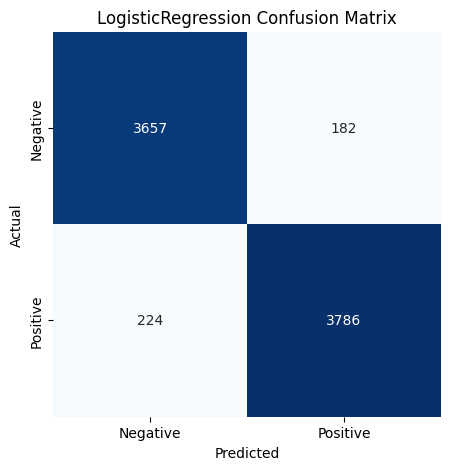

True Positive (TP): 3786
True Negative (TN): 3657
False Positive (FP): 182
False Negative (FN): 224


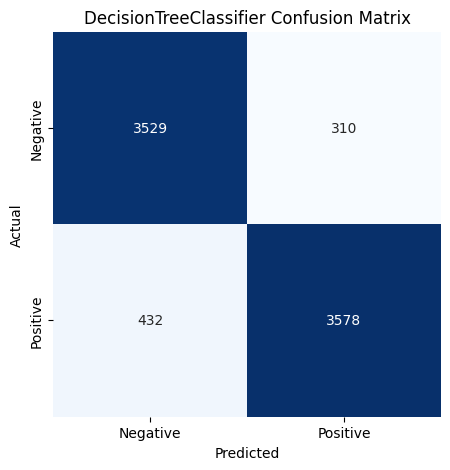

True Positive (TP): 3578
True Negative (TN): 3529
False Positive (FP): 310
False Negative (FN): 432


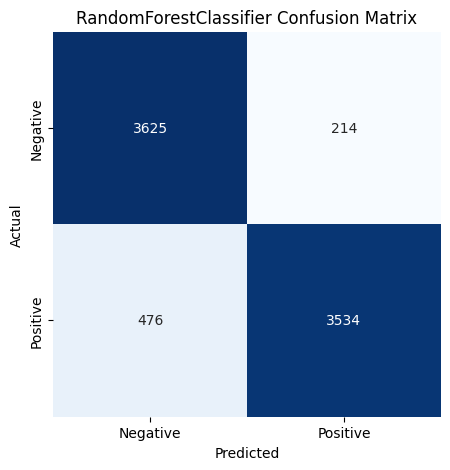

True Positive (TP): 3534
True Negative (TN): 3625
False Positive (FP): 214
False Negative (FN): 476


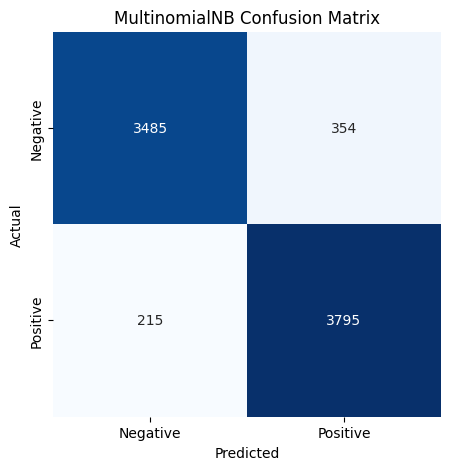

True Positive (TP): 3795
True Negative (TN): 3485
False Positive (FP): 354
False Negative (FN): 215


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix for each model
for model_name, model in models.items():
    X_test_tfidf = vectorizer.transform(X_test['clean_review'])
    
    positive_word_count = X_test['clean_review'].apply(lambda review: count_sentiment_words(review, positive_words))
    negative_word_count = X_test['clean_review'].apply(lambda review: count_sentiment_words(review, negative_words))
    
    X_test_features = hstack([X_test_tfidf, np.array([positive_word_count, negative_word_count]).T])
    y_pred = model.predict(X_test_features)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    TN, FP, FN, TP = cm.ravel()
    
    print(f"True Positive (TP): {TP}")
    print(f"True Negative (TN): {TN}")
    print(f"False Positive (FP): {FP}")
    print(f"False Negative (FN): {FN}")


In [19]:
%load_ext autoreload
%autoreload 2
from aifeel.util.evaluate import evaluate_model

d:\CS-Term 10\NLP\Mini Project 2\aifeel\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\CS-Term 10\NLP\Mini Project 2\aifeel\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

LogisticRegression Evaluation:

Cross-Validation Scores: [0.92770701 0.93566879 0.94267516 0.93789809 0.94775406 0.94552405
 0.94297547 0.94807263 0.94138261 0.93947117]

Cross-Validation Average Score: 0.94

Accuracy Scores: 0.9482736654350873

Classification Report:

precision    recall  f1-score   support

           0       0.94      0.95      0.95      3839
           1       0.95      0.94      0.95      4010

    accuracy                           0.95      7849
   macro avg       0.95      0.95      0.95      7849
weighted avg       0.95      0.95      0.95      7849

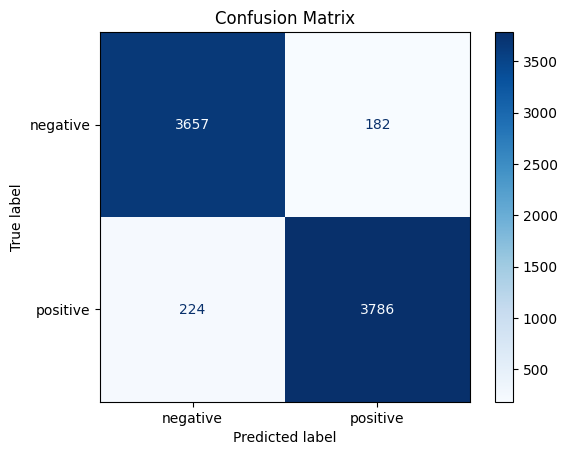

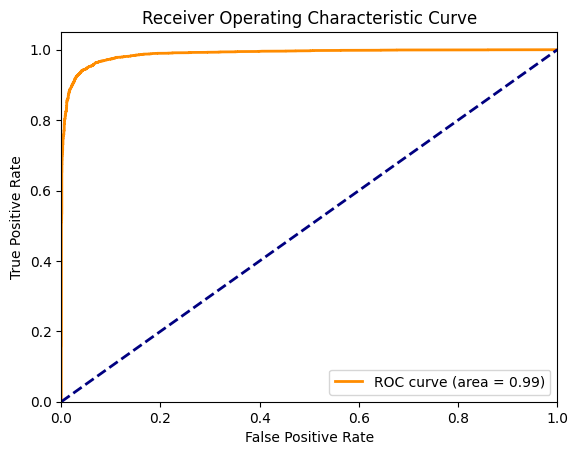

MultinomialNB Evaluation:

Cross-Validation Scores: [0.90541401 0.90509554 0.91242038 0.92006369 0.92099395 0.92003823
 0.91557821 0.91430392 0.91366677 0.91589678]

Cross-Validation Average Score: 0.91

Accuracy Scores: 0.9275066887501593

Classification Report:

precision    recall  f1-score   support

           0       0.94      0.91      0.92      3839
           1       0.91      0.95      0.93      4010

    accuracy                           0.93      7849
   macro avg       0.93      0.93      0.93      7849
weighted avg       0.93      0.93      0.93      7849

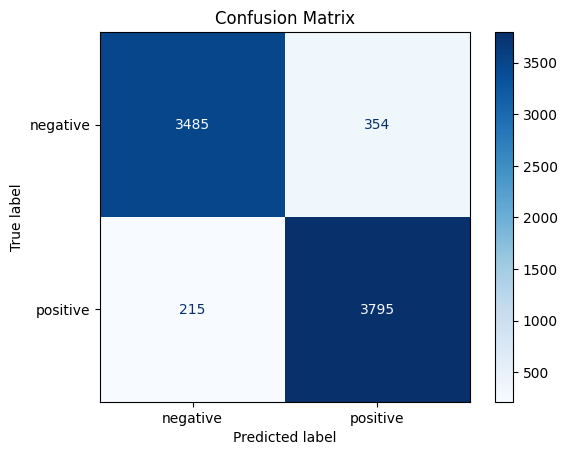

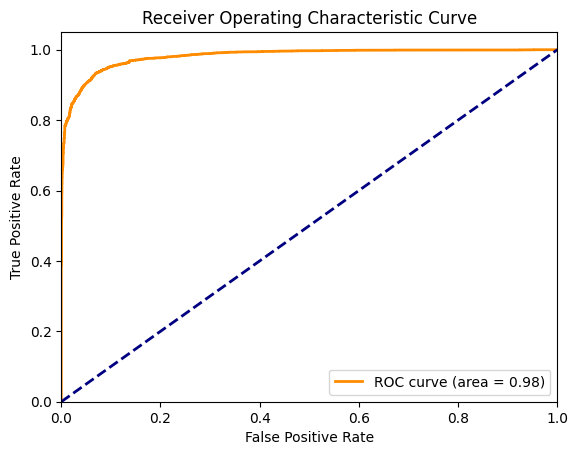

In [20]:
for model_name, model in models.items():
    if model_name == 'LogisticRegression':
        evaluate_model(LogisticRegression(C=10),model,model_name, X_train_features,y_train,X_test_features,y_test)
    if model_name == 'MultinomialNB':
        evaluate_model(MultinomialNB(alpha=1),model,model_name, X_train_features,y_train,X_test_features,y_test)



In [21]:
import os
from pathlib import Path
import dill

export_base = Path("../../../export/model/TFIDFModelClassifier")

if not os.path.exists(export_base):
    export_base.mkdir(parents=True, exist_ok=True)

In [22]:
for model_name, model in models.items():
    if model_name == 'LogisticRegression':
        with open(export_base /'logistic_regression_model.dill', 'wb') as file:
            dill.dump(model, file)
    if model_name == 'MultinomialNB':
        with open(export_base /"multinomial_nb_model.dill", 'wb') as file:
            dill.dump(model, file)

# with open(export_base / "vectorizer.dill", "wb") as f:
#     dill.dump(vectorizer, f)
    
with open(export_base / "data.npz", "wb") as f:
    np.savez_compressed(
        f,
        X_train=X_train_features,
        X_test=X_test_features,
        y_train=y_train,
        y_test=y_test
    )

In [23]:
with open("../../../export/model/TFIDFModelClassifier/logistic_regression_model.dill", "rb") as f:
    loaded_model = dill.load(f)

In [24]:
data = np.load('../../../export/model/TFIDFModelClassifier/data.npz', allow_pickle=True)

# Access the arrays stored in the .npz file
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [ ]:
#evaluate_model(LogisticRegression(C=10), loaded_model, "LogisticRegression", X_train, y_train, X_test,y_test=y_test)